<center>

# **K-Means Minus Minus for new cluster detection**

## made by:

| Researcher        | Registration | Email                    |
|-------------------|--------------|--------------------------|
| Vitor Hugo Duarte | 496348       | vitor02hugo@alu.ufc.br   |

</center>


### Initializing Enviroment and Collecting Data

- Source: https://archive.ics.uci.edu/static/public/231/

    ```
    This dataset comes inside two Zip folders, so, we have to process it to let it on a
    format that we can handle it more easly, also it's reaaaly huge, so i'll be using
    parquet format to store all this data.
    ```

In [1]:
import sys
from io import BytesIO
from pathlib import Path
from zipfile import ZipFile

import torch
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Get my_package directory path from Notebook
sys.path.insert(0, str(Path().resolve().parents[1]) + "/src/")

from kmeansmm import KMeansMM


pd.set_option("display.max_columns", None)

URL = "https://archive.ics.uci.edu/static/public/231/pamap2+physical+activity+monitoring.zip"
DATA_FOLDER = "../../data"
COLUMN_NAMES = ["timestamp", "activityID", "heartrate"]

IMU_HAND = [
    "handTemperature",
    "handAcc16_1",
    "handAcc16_2",
    "handAcc16_3",
    "handAcc6_1",
    "handAcc6_2",
    "handAcc6_3",
    "handGyro1",
    "handGyro2",
    "handGyro3",
    "handMagne1",
    "handMagne2",
    "handMagne3",
    "handOrientation1",
    "handOrientation2",
    "handOrientation3",
    "handOrientation4",
]

IMU_CHEST = [
    "chestTemperature",
    "chestAcc16_1",
    "chestAcc16_2",
    "chestAcc16_3",
    "chestAcc6_1",
    "chestAcc6_2",
    "chestAcc6_3",
    "chestGyro1",
    "chestGyro2",
    "chestGyro3",
    "chestMagne1",
    "chestMagne2",
    "chestMagne3",
    "chestOrientation1",
    "chestOrientation2",
    "chestOrientation3",
    "chestOrientation4",
]

IMU_ANKLE = [
    "ankleTemperature",
    "ankleAcc16_1",
    "ankleAcc16_2",
    "ankleAcc16_3",
    "ankleAcc6_1",
    "ankleAcc6_2",
    "ankleAcc6_3",
    "ankleGyro1",
    "ankleGyro2",
    "ankleGyro3",
    "ankleMagne1",
    "ankleMagne2",
    "ankleMagne3",
    "ankleOrientation1",
    "ankleOrientation2",
    "ankleOrientation3",
    "ankleOrientation4",
]

columns = COLUMN_NAMES + IMU_HAND + IMU_CHEST + IMU_ANKLE

In [2]:
def mount_dataset() -> None:
    try:
        print("Requesting Dataset... ", end=" ")
        with ZipFile(
            BytesIO(requests.get(URL, timeout=160, stream=True).content)
        ) as myzip:
            with ZipFile(myzip.open(myzip.namelist()[0])) as file:
                # Extract all the contents of zip file in current directory
                file.extractall(DATA_FOLDER)

    except Exception as exc:
        raise exc


def load_dataset() -> pd.DataFrame:
    df = pd.DataFrame()
    try:
        for file in Path(DATA_FOLDER + "/PAMAP2_Dataset/Protocol").glob("**/*.dat"):
            print("reading: ", file.name)
            df = pd.concat(
                [df, pd.read_csv(file, sep=" ", names=columns)], ignore_index=True
            )
        for file in Path(DATA_FOLDER + "/PAMAP2_Dataset/Optional").glob("**/*.dat"):
            print("reading: ", file.name)
            df = pd.concat(
                [df, pd.read_csv(file, sep=" ", names=columns)], ignore_index=True
            )
        print("Dataset Loaded, saving... ", end=" ")
        Path(DATA_FOLDER + "/PAMAP2").mkdir(parents=True, exist_ok=True)
        df.to_parquet(DATA_FOLDER + "/PAMAP2/protocol.parquet")
        print("Done!")

    except Exception as e:
        raise e

    return df

In [2]:
df = pd.read_parquet(DATA_FOLDER + "/PAMAP2/protocol.parquet")
df.head()

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,handMagne2,handMagne3,handOrientation1,handOrientation2,handOrientation3,handOrientation4,chestTemperature,chestAcc16_1,chestAcc16_2,chestAcc16_3,chestAcc6_1,chestAcc6_2,chestAcc6_3,chestGyro1,chestGyro2,chestGyro3,chestMagne1,chestMagne2,chestMagne3,chestOrientation1,chestOrientation2,chestOrientation3,chestOrientation4,ankleTemperature,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4
0,5.64,0,NaN,33.0,2.79143,7.55389,-7.06374,2.87553,7.88823,-6.76139,1.01640,-0.289410,1.38207,-11.6508,-3.736830,31.1784,1.0,0.0,0.0,0.0,36.125,1.94739,9.59644,-3.12873,1.81868,9.49711,-2.91989,0.124025,0.112482,-0.044947,-20.2905,-32.0492,8.67906,1.000000,0.000000,0.000000,0.000000,33.8125,9.84408,-0.808951,-1.64674,9.73055,-0.846832,-1.29665,-0.027148,-0.031190,-0.040897,-47.7695,-2.58701,59.8481,-0.012871,0.747947,-0.079841,0.658813
1,5.65,0,NaN,33.0,2.86086,7.43814,-7.21626,2.84248,7.63164,-6.85140,1.08269,-0.393965,1.60935,-11.6575,-3.186480,30.7215,1.0,0.0,0.0,0.0,36.125,1.75120,9.63340,-3.32601,1.74445,9.69355,-2.96421,0.132679,0.060829,-0.044168,-20.6409,-31.6989,8.30648,1.000000,0.000000,0.000000,0.000000,33.8125,9.83968,-0.807666,-1.80115,9.73049,-0.816601,-1.31189,0.012804,-0.036384,-0.014845,-47.7624,-2.81438,60.3407,0.014025,-0.748410,0.079043,-0.658360
2,5.66,0,100.0,33.0,2.80997,7.09430,-7.52376,2.79373,7.43545,-7.07744,1.14829,-0.521087,1.80748,-11.7615,-2.530610,30.9612,1.0,0.0,0.0,0.0,36.125,1.67059,9.70790,-3.48260,1.63773,9.70924,-3.22043,0.074772,0.124062,-0.053608,-20.0831,-31.4975,8.68295,0.097324,0.000434,0.809587,0.578875,33.8125,9.69127,-0.769071,-1.76432,9.73032,-0.756157,-1.35749,-0.001695,-0.034529,-0.040074,-47.5393,-2.38909,60.9623,0.012714,-0.749508,0.075286,-0.657577
3,5.67,0,NaN,33.0,2.77138,6.98077,-7.52396,2.80627,7.29929,-7.24326,1.24888,-0.511985,1.95031,-11.2109,-2.121300,30.4964,1.0,0.0,0.0,0.0,36.125,1.66925,9.63234,-3.52110,1.53244,9.72459,-3.23487,0.063729,0.136592,0.004851,-20.5186,-31.9253,8.18545,0.099487,-0.002908,0.805891,0.583639,33.8125,9.80276,-0.921656,-1.76223,9.70051,-0.816589,-1.29659,0.055437,-0.011560,0.015434,-47.4246,-2.72082,60.7103,0.012639,-0.749201,0.076030,-0.657843
4,5.68,0,NaN,33.0,2.76710,7.13119,-7.67848,2.78766,7.11797,-7.48445,1.27178,-0.525704,2.01367,-10.8648,-0.621037,30.7401,1.0,0.0,0.0,0.0,36.125,1.58969,9.66945,-3.63882,1.51648,9.66438,-3.32562,0.008942,0.107000,0.003266,-19.7185,-32.1801,8.68756,0.114907,-0.023002,0.813036,0.570298,33.8125,9.68318,-0.842759,-2.03407,9.73043,-0.816620,-1.32702,0.017184,-0.034663,0.007239,-47.5412,-2.60153,60.3412,0.012571,-0.749291,0.076346,-0.657705


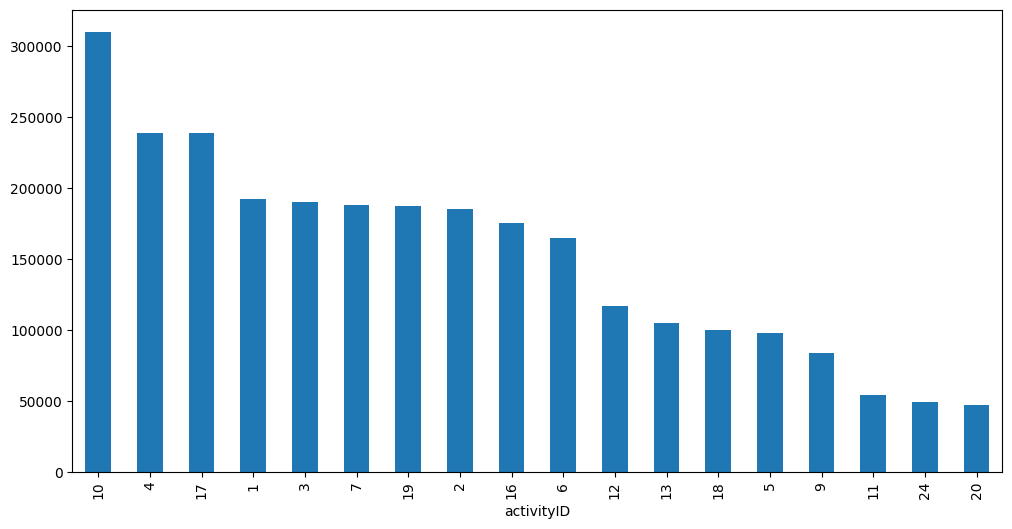

In [3]:
def dataCleaning(dataCollection):
    # removal of transient activity which it is not used
    dataCollection = dataCollection.drop(
        dataCollection[dataCollection.activityID == 0].index
    )
    # removal of non numeric data in cells
    dataCollection = dataCollection.apply(pd.to_numeric)
    # removal of any remaining NaN value cells by constructing new data points in known set of data points
    dataCollection = dataCollection.interpolate()

    return dataCollection


# sum classes in activityID
df = dataCleaning(df)
df["activityID"].value_counts().plot(kind="bar", figsize=(12, 6))
plt.show()

In [ ]:
X = df.drop(["activityID"], axis=1)
y = df["activityID"]

# Bounded region of parameter space
pbounds = {
    "n_clusters": (2, 18),
    "l": (0, 4),
    "max_iter": (800, 2800),
    "tol": (1e-4, 1e-1),
}


# Define the objective function to maximize (in this case, silhouette score)
def kmeans_objective(n_clusters, l, max_iter, tol):
    kmeans = KMeansMM(
        n_clusters=int(n_clusters),
        l=int(l),
        max_iter=int(max_iter),
        tol=tol,
    )
    kmeans.fit(torch.Tensor(X.values))
    return silhouette_score(X, kmeans.predict(torch.Tensor(X.values)))


# Initialize BayesianOptimization
optimizer = BayesianOptimization(
    f=kmeans_objective,
    pbounds=pbounds,
    random_state=101,
)

# Perform optimization
optimizer.maximize(init_points=10, n_iter=10)
print("Best hyperparameters:", optimizer.max["params"])

In [ ]:
cluterer = KMeansMM(n_clusters=18, max_iter=4800)
y_pred = cluterer.fit_predict(torch.Tensor(X.values))
centroids = cluterer.centroids.numpy()

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap="viridis")
plt.scatter(
    centroids[:, 0], centroids[:, 1], marker="+", s=200, c="red", label="Centroids"
)
h = 0.02

# construct mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# obtain labels per mesh point (reuse stored model)
Z = cluterer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# put result into color plot
plt.title("KMeans-- Clustering")
plt.imshow(
    Z,
    interpolation="nearest",
    cmap="Set2",
    alpha=0.75,
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
)